## Weather Image classifcation for four different classes such as cloudy, rain, shine, sunrise.

### Table of Contents

* [1.Data Retrival and Formation](#chapter1)
    * [1.1 Data Analysis](#section_1_1)
* [2.Train-Test Split](#chapter2)
    * [2.1 Train Set](#section_2_1)
        * [2.1.1 Data Augmentation](#section_2_1_1)
    * [2.2 Test Set](#section_2_2)
    * [2.3 Valid Set](#section_2_3)
* [3. Dataset & DataLoader](#chapter3)
* [4.Initial Model](#chapter4)
* [5.Evaluation](#chapter5)
    * [5.1 Classification Report](#section_5_1)
* [6.Prediction](#chapter6)

In [1]:
#Import essential library to build model and data processing.
import numpy as np
import pandas as pd
import os
import cv2
import glob
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms ,models
from torch import optim
from torch.autograd import Variable
import torch.utils.data as data_utils
from torch.utils.data import DataLoader,Dataset

In [3]:
#check device is cpu or gpu.
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
#mount google drive where my data is stored
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# link from where we can retrived the data  and the extension of the images to usd while create labels.
data = '/content/drive/MyDrive/wdata'
ext = ['png', 'jpg', 'jpeg'] 

 <a name="chapter1"></a>
# 1) Data Retrival and Formation

we store the data in drive using link we retrived the data and perform certain operation to get into formation for the model.

In [6]:
# we will read image file names and store in list format
image_name = os.listdir(data)
print(len(image_name))
print(image_name[0])

836
cloudy100.jpg


In [7]:
def generate_label(target, ext):
  '''it will remove the extension of the image and 
  numeric values present in image name to create the label'''
  df = pd.DataFrame(target, columns = ['label'])
  for e in ext:
    df['label'] = df['label'].str.rstrip('.' + e)
  df['label'] = df['label'].str.replace('\d+', '')
  return df

In [8]:
df_label = generate_label(image_name, ext)

In [9]:
def get_image(data, image_name):
  '''it will read the images and stored it inside dataframe.'''
  files = []
  [files.extend(glob.glob(data +  '/' + e)) for e in image_name] 
  images = [cv2.imread(file) for file in files]
  df_image = pd.DataFrame(images, columns=['image'])
  return df_image

In [10]:
df_image = get_image(data, image_name)

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [11]:
# replace the labels with numeric values and indexing start from the 0 and concat the two datadrame in one.
df_label['label'] = df_label['label'].map( {'cloudy':0 , 'shine':1, 'rain':2, 'sunrise':3} )
weather_data = pd.concat([df_image, df_label], axis = 1)
weather_data

,image,label
0,"[[[145, 135, 135], [148, 138, 138], [155, 143,...",0
1,"[[[216, 209, 212], [216, 209, 212], [216, 209,...",0
2,"[[[223, 192, 177], [217, 186, 171], [215, 184,...",0
3,"[[[125, 125, 125], [126, 126, 126], [128, 128,...",0
4,"[[[105, 79, 65], [104, 78, 64], [103, 77, 63],...",0
...,...,...
831,"[[[64, 74, 134], [64, 74, 134], [63, 73, 133],...",3
832,"[[[37, 39, 79], [45, 47, 95], [56, 58, 112], [...",3
833,"[[[53, 88, 138], [53, 88, 138], [53, 88, 138],...",3
834,"[[[29, 56, 83], [29, 56, 83], [29, 56, 83], [2...",3


<a name="section_1_1"></a>
# 1.1) Data Analysis
Distribution of the dataset across four diffent classes is not balance. Particulary the sunrise class related images are low due to which perform the data augmentation to task on class 3.

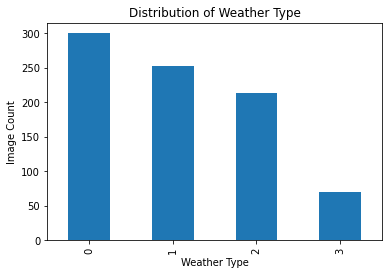

In [12]:
ax = weather_data['label'].value_counts().plot(kind='bar')
ax.set_xlabel("Weather Type")
ax.set_ylabel("Image Count")
ax.title.set_text("Distribution of Weather Type")

<a name="chapter2"></a>
# 2) Train-Test Split

split the data into three section train, test, and valid.
<a name="section_2_2"></a>
# 2.2) Test Split: 10% total data
<a name="section_2_3"></a>
# 2.2) valid Split: 15% train data

In [13]:

train_data, test_data = train_test_split(weather_data,test_size=0.1)
train_data, valid_data = train_test_split(train_data,test_size=0.15)
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(639, 2)
(113, 2)
(84, 2)


<a name="section_2_1"></a>
# 2.1) Train split and Distribution detect imbalance dataset.

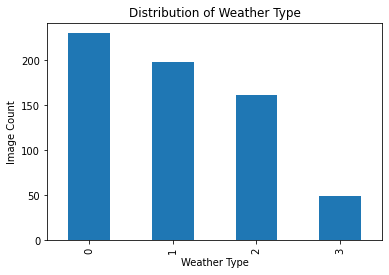

In [14]:
ax = train_data['label'].value_counts().plot(kind='bar')
ax.set_xlabel("Weather Type")
ax.set_ylabel("Image Count")
ax.title.set_text("Distribution of Weather Type")

In [15]:
image_aug = train_data[train_data['label'] == 3]

<a name="section_2_1_1"></a>
# 2.1.1) Data Augmentation

We horizontally flip the images related to sunrise label (3) and concate the data with the train set. Basically, we used for loop to iterate through the images and store it inside the dataframe. To flip horizontally used flip function and pass the argument 1. Actually, there are other techniques as well such as add noise in image, blur image, vertically flip, horizonatal and vertical flip,  and many others.

In [16]:
def image_augmentation(dataframe):
  for i in range (len(dataframe.index)):
    dataframe.image.iloc[i] = cv2.flip(dataframe.image.iloc[i], 1)
  return dataframe

In [17]:
data_image_augment = image_augmentation(image_aug)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Data distribution after the data augmentation where we can find the label 3 related data is doubled.

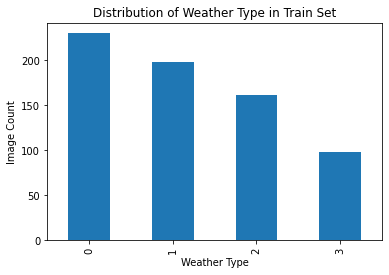

In [18]:
train_data_aug = pd.concat([train_data, data_image_augment])
ax = train_data_aug['label'].value_counts().plot(kind='bar')
ax.set_xlabel("Weather Type")
ax.set_ylabel("Image Count")
ax.title.set_text("Distribution of Weather Type in Train Set")

<a name="chapter3"></a>
# 3) Dataset & Dataloader 
For next two cell we prapared the dataset and dataloader using the pytorch functionality. First, we passed the dataframe and transform which is one of the functionality build by pytorch to perform vision related augmentation experiments. Using the transform we can convert images into the tensor and resize it, read it it using ToPILImage and rotate the image in random angle also flip the images horizontally. The ImageDataset class below, convert the labels into numpy array as well, and store it inside the dictionary and return it. After that, we have used the pytorch dataloader and set the batch size for train, test, and valid, set the shuffle is True.

In [19]:
class ImageDataset(Dataset):
  def __init__(self, dataframe, transform):
    self.dataframe = dataframe
    self.transform=transform    
    self.image=self.dataframe['image']
    self.labels=np.array(self.dataframe['label'])
  
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,index):
    
    image=self.transform(self.image.iloc[index])
    targets=self.labels[index]
    sample = {'image': image,'labels':targets}
    return sample

In [20]:
train_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomRotation(degrees=45),
                transforms.ColorJitter(),
                transforms.ToTensor()])

valid_transform =transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor()])

test_transform =transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor()])

train_dataset=ImageDataset(train_data_aug, train_transform)
valid_dataset=ImageDataset(valid_data, valid_transform)
test_dataset=ImageDataset(test_data, test_transform)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=8,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size=4,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=4,
    shuffle=True
)

<a name="chapter4"></a>
# 4) Inital Model
We have used the Resnext18 pre-trained model which will have residual connections and pretrained model gives us advantage as we have weights already due to which model do not need start from the scratch. It gives little boost to the model while training. After that we have used our own classifier block in which we set two drop out layer with 0.2 probability and used the weight_decay(L2 Regularization technique) to prevent the overfitting and exploiting gradient issue. we have used the cross entropy loss and adam optimizer with learning rate set to 0.0001.

In [21]:
class resnet18_model(nn.Module):
    def __init__(self):
        super(resnet18_model, self).__init__()
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        classifier = nn.Sequential(
                     nn.Linear(self.model.fc.in_features,1024),
                     nn.Dropout(p = 0.3),
                     nn.ReLU(),
                     nn.Linear(1024,512),
                     nn.Dropout(p = 0.2),
                     nn.ReLU(),
                     nn.Linear(512, 4),
                     nn.LogSoftmax(dim = 1))   
        self.model.fc = classifier        

    
    def forward(self, image): #
        x = self.model(image)
        return x


model = resnet18_model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 3e-5)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

resnet18_model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

### We perform the training and evaluation of the model. In training, we trained the model and after every epoch we used the validation block and plot the result of the model. we trained our model for 5 epochs

In [22]:
def fit(n_epochs, 
        model, 
        device, 
        train_loader, 
        valid_loader, 
        criterion, 
        optimizer):
    '''It will perform model training and validation.'''
    epochs = n_epochs
    history = []
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        running_loss = 0
        valid_loss = 0
        train_acc = 0
        valid_acc = 0

        # Model Training
        for sample in train_loader:
            images = sample['image']
            labels = sample['labels']
            # data and target value on device either a CPU or GPU.
            images = images.to(device=device, dtype = torch.float)
            labels = labels.to(device=device, dtype = torch.long)
            # Clear gradients
            optimizer.zero_grad()
            # Predicted images outputs
            outputs = model(images)
            #calculate the loss between prediction and target values
            loss = criterion(outputs, labels)
            #backpropogation of gradients
            loss.backward()
            #update the parameter
            optimizer.step()
            # Store the loss in variable
            running_loss += loss.item()
            # model's prediction using the max probability
            _, pred = torch.max(outputs, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            #convert the tensor
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            #track the accuracy
            train_acc += accuracy.item()

        # Validation Model
        # Don't need to keep track of gradients
        with torch.no_grad():
            # set model to evaluate model
            model.eval()
            for sample in valid_loader:
                images = sample['image']
                labels = sample['labels']
                # data and target on deivece and datatype decision
                images = images.to(device=device, dtype = torch.float)
                labels = labels.to(device=device, dtype = torch.long)
                #prediction of the model
                output = model(images)
                #calculate valid loss
                valid_loss += criterion(output, labels)
                #calculate the accuracy and convert the type
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(labels.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                #calculate accuracy to keet track
                valid_acc += accuracy.item()
            #store loss and accuracy in list
            history.append([running_loss /
                            len(train_loader), train_acc /
                            len(train_loader), valid_loss /
                            len(valid_loader), valid_acc /
                            len(valid_loader), epoch])
            # save the model if valid loss decrease
            if valid_loss <= valid_loss_min:
                torch.save(model.state_dict(), 'best_model_weather.pth')
                valid_loss_min = valid_loss
    return model, history

In [23]:
model, history = fit(5, model, device, train_dataloader, valid_dataloader, criterion, optimizer)

In [24]:
train_history = pd.DataFrame(history, columns = ['train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'epoch'])

In [25]:
def training_loss_performance(dataframe: pd.DataFrame):
    '''It used the history generated from the training to plot the train vs valid loss.'''
    plt.plot(dataframe['epoch'], dataframe['train_loss'], 'r', label='Training loss')
    plt.plot(dataframe['epoch'], dataframe['valid_loss'], 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

def train_acc_performance(dataframe: pd.DataFrame):
    '''It used the history generated from the training to plot the train vs valid accuracy.'''
    plt.plot(dataframe['epoch'], dataframe['train_acc'], 'r', label='Training acc')
    plt.plot(dataframe['epoch'], dataframe['valid_acc'], 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

The train and valid loss and accuracy plot.

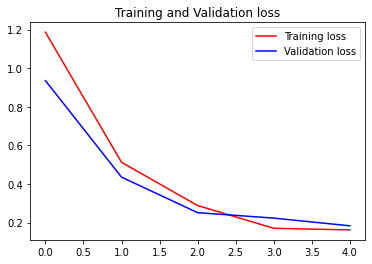

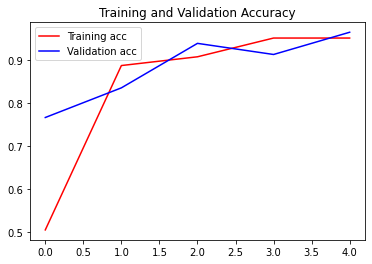

In [26]:
training_loss_performance(train_history)
train_acc_performance(train_history)

<a name="chapter5"></a>
# 5) Model Evaluation 
Here, we evaluate the model's performance over the test data and we use the classificatoin report to measure the results. Where we can find each class related precision, recall, and f1 score.

In [27]:
def evaluation(device, 
               model, 
               test_loader):
    '''It will perform model testing and store the actual target and predicted result into list.'''
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for sample in test_loader:
            images = sample['image']
            labels = sample['labels']
            images = images.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)
            output = model(images)
            _, output = torch.max(output, dim=1)
            fin_targets.extend(labels.cpu().detach().numpy().tolist())
            fin_outputs.extend(output.cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [28]:
outputs, targets = evaluation(device, model, test_dataloader)

In [29]:
print(sklearn.metrics.classification_report(outputs, targets))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        25
           1       0.96      0.86      0.91        29
           2       1.00      1.00      1.00        22
           3       1.00      0.75      0.86         8

    accuracy                           0.93        84
   macro avg       0.95      0.90      0.92        84
weighted avg       0.94      0.93      0.93        84



<a name="chapter6"></a>
# 6) Prediction

The colleague can used the save model to perform the prediction. As per below steps:

In [30]:
ckpt = torch.load('best_model_weather.pth')

In [31]:
def imshow(image, ax=None, title=None, normalize=False):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# Here, model detect the prediction for image which is 0 related to class "cloud" and it's correct prediction.

tensor([0], device='cuda:0')


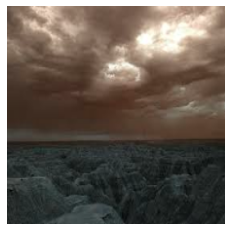

In [35]:
sample = next(iter(test_dataloader))
images = sample['image']
targets = sample['labels']
a1 = imshow(images[0])
images, labels = images.to(device), targets.to(device)
img = images[0].view(1,3,224,224)

with torch.no_grad():
    model = model.to(device)
    logits = model(img)
    
_, output = torch.max(logits, dim=1)
print(output)
